import modules

In [56]:
import torch as t
from torch.distributions import normal, uniform
import matplotlib.pyplot as plt
import numpy as np

# Goal

Sample from the posterior distribution $p(\theta|D)$, given a set of independent observations $x \in D$.

$$p(\theta|D) \propto exp(-U(\theta))$$

U := Potential Energy

$$U = - \sum_{x \in D} log p(x|\theta) - log p(\theta) $$

## Hamiltonian Monte-Carlo

Hamiltonian (Hybrid) Monte Carlo (HMC) (Duane et al., 1987; Neal, 2010) provides a method for proposing samples of $\theta$ in a Metropolis-Hastings (MH) framework that efficiently explores the state space as compared to standard random-walk proposals.

proposals are generated from a Hamiltonian system based on introducing a set
of auxiliary momentum variables, $r$. That is, to sample
from $p(\theta|D)$, HMC considers generating samples from a joint distribution of $(\theta, r)$ defined by:

$$
\pi(\theta,r) \propto exp(-U(\theta) - \frac{1}{2} r^T M^{-1} r)
$$

Here, we can define the Hamiltonian energy of the system as:

$$
H(\theta,r) = U(\theta) + \frac{1}{2} r^T M^{-1} r
$$

Intuitively, $H$ measures the total energy of a physical system with position variables $\theta$ and momentum variables $r$.

To propose samples, HMC simulates the Hamiltonian dynamics of the system:

$$
d\theta = M^{-1}r \text{ dt} \\
dr = - \nabla U(\theta) \text{ dt}
$$

### Hockey-Puck analogy

<img src="./images/HMC.jpg" height="400">

### The need for acceptance rates

Over any interval $s$, the Hamiltonian dynamics of Eq. (4)
defines a mapping from the state at time $t$ to the state at
time $t + s$. Importantly, this mapping is reversible, which
is important in showing that the dynamics leave $\pi$ invariant. Likewise, the dynamics preserve the total energy, $H$,
so proposals are always accepted. 

In practice, however, we usually cannot simulate exactly from the continuous system
of Eq. (4) and instead consider a discretized system. One common approach is the “leapfrog” method, which is outlined below. Because of inaccuracies introduced through the discretization, an MH step must be implemented (i.e.,
the acceptance rate is no longer 1). However, acceptance
rates still tend to be high even for proposals that can be
quite far from their last state.

### HMC algorithm

<img src="./images/HMC_alg.PNG" height="400">

In [59]:
def HMC(theta: t.Tensor, step_size: float, grad_fn, H, m:int):
    c = 0
    while True:
        c += 1
        #print(f"step: {c}")
        # resample momentum r
        r = normal.Normal(0, 1).sample()
        # simulate the discretization of Hamiltonian dynamics
        theta_star = theta.detach().clone()
        r_star = r - step_size/2 * grad_fn(theta)
        for i in range(m):
            theta_star = theta_star + step_size * r_star
            r_star = r_star - step_size * grad_fn(theta_star)
        r_star = r_star - step_size/2 * grad_fn(theta_star)
        # Metropolis-Hastings correction
        u = uniform.Uniform(0,1).sample()
        rho = t.exp(H(theta_star, r_star) - H(theta, r))
        if u < min(1, rho):
            return theta_star, r_star

In [60]:
def grad_fn(theta):
    return theta

def H(theta, r):
    return (1/2) * theta**2 + (1/2) * r**2

In [94]:
step_size = 0.05
theta_init = uniform.Uniform(-1.,1.).sample()
m = 10

thetas = []
r_vals = []
for i in range(10_000):
    theta, r = HMC(theta_init, step_size, grad_fn, H, m)
    thetas.append(theta)
    r_vals.append(r)

#plt.plot(thetas, r_vals)

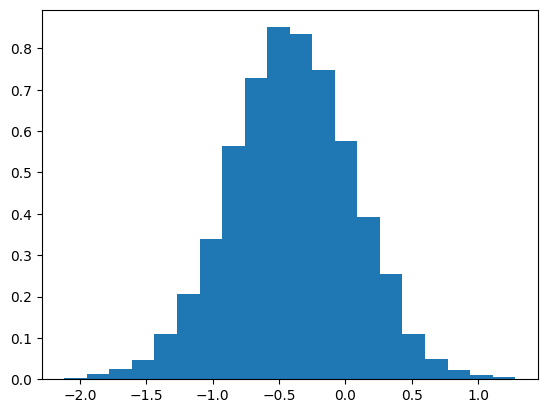

In [95]:
plt.hist(thetas, density=True, bins=20)
plt.show()